In [ ]:
"""Copyright 2017 Google, Inc. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

----
Original script can be found at

    https://github.com/dandelionmane/tf-dev-summit-tensorboard-tutorial

And is similar to the TensorFlow tutorial script found at

    https://www.tensorflow.org/get_started/mnist/mechanics
"""
import tqdm
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.logging.set_verbosity(tf.logging.ERROR)
from IPython.display import Image
#
#  Script variables. Change these and observe
#  how results change.
#
LEARNING_RATE = 0.0001
EPOCHS = 2000
#
#  Script constants. Here we pull data available
#  locally. The data contains both the sprites
#  and the labels from the original MNIST dataset.
#
LOGDIR = "mnist_example/"
LABELS = os.path.join(os.getcwd(), 'Dataset1/labels_1024.tsv')
SPRITES = os.path.join(os.getcwd(), 'Dataset1/sprite_1024.png')

def load_data():
    """Load data form the MNIST dataset into memory.

    Returns
    -------
    TensorFlow object with dataset.
    """
    return tf.contrib.learn.datasets.mnist.read_data_sets(
        train_dir=LOGDIR + "data", one_hot=True)


def convolutional_layer(input, size_in, size_out, name="convolutional"):
    """Convoluted layer.

    Create the weights and biases distributions.
    Also define the convolution and the activation function (ReLU).
    Finally, we create some histogram summaries useful for TensorBoard.

    Parameters
    ----------
    size_in, size_out: int or float
        Where to truncate the normal distribution.

    name: str
        Name to give the TensorFlow scope.
    """
    with tf.name_scope(name):

        W = tf.Variable(tf.truncated_normal([5, 5, size_in, size_out], stddev=0.1), name="Weights")
        B = tf.Variable(tf.constant(0.1, shape=[size_out]), name="Biases")

        convolution = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding="SAME")
        activation = tf.nn.relu(convolution + B)

        tf.summary.histogram("weights", W)
        tf.summary.histogram("biases", B)
        tf.summary.histogram("activations", activation)

        return tf.nn.max_pool(activation, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")


def fully_connected_layer(input, size_in, size_out, name="fully_connected"):
    """Fully connected layer.

    This defines the fully connected layer.
    Different from the convolution layer, this layer does not
    perform a convolution but only defines an activation function.
    That function is also different from the convolution layer
    by multipliying the input data with its weights plus the biases,
    which is a much simpler activation function than ReLU.

    Parameters
    ----------
    size_in, size_out: int or float
        Where to truncate the normal distribution.

    name: str
        Name to give the TensorFlow scope.
    """
    with tf.name_scope(name):
        W = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="Weights")
        B = tf.Variable(tf.constant(0.1, shape=[size_out]), name="Biases")

        activation = tf.matmul(input, W) + B

        tf.summary.histogram("weights", W)
        tf.summary.histogram("biases", B)
        tf.summary.histogram("activations", activation)

        return activation


def model(mnist, learning_rate, epochs=2000):
    """Neural network model used in the MNIST dataset.

    Parameters
    ----------
    mnist: TensorFlow dataset object
        MNIST dataset loaded using TensorFlow.

    learning_rate: float
        Learning rate at which the network should
        create momentum.

    epochs: int, default 2000
        Number of epochs to train the model with.
    """
    name = "MNIST-model/lr={}-epochs={}".format(learning_rate, epochs)

    tf.reset_default_graph()
    sess = tf.Session()

    X = tf.placeholder(tf.float32, shape=[None, 784], name="X")
    X_image = tf.reshape(X, [-1, 28, 28, 1])
    tf.summary.image('input', X_image, 3)

    Y = tf.placeholder(tf.float32, shape=[None, 10], name="Labels")

    #
    #  Convolutional layer treatment. We use a single convolutional layer.
    #
    convolution = convolutional_layer(X_image, 1, 64, "Convolution_Layer")
    convolution_output = tf.nn.max_pool(convolution, ksize=[1, 2, 2, 1],
                                        strides=[1, 2, 2, 1], padding="SAME")

    flattened = tf.reshape(convolution_output, [-1, 7 * 7 * 64])

    #
    #  Fully-connected layer treatment.
    #  We will use two fully connected layers
    #  that connect to each other. We can
    #  try more or less to see the impact
    #  on our model.
    #
    fully_connected_1 = fully_connected_layer(flattened, 7 * 7 * 64, 1024,
                                              "Fully-connected_Layer_1")
    relu = tf.nn.relu(fully_connected_1)
    embedding_input = relu
    tf.summary.histogram("Fully-connected_Layer-1/relu", relu)

    embedding_size = 1024
    logits = fully_connected_layer(fully_connected_1, 1024, 10,
                                   "Fully-connected_Layer_2")

    with tf.name_scope("Cross_Entropy"):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y), name="cross_entropy")
        #cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y), name="cross_entropy")
        tf.summary.scalar("cross_entropy", cross_entropy)

    with tf.name_scope("Train"):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

    with tf.name_scope("Accuracy"):
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        tf.summary.scalar("Accuracy", accuracy)

    summ = tf.summary.merge_all()

    #
    #  Let's save embeddings so that they
    #  are available in TensorBoard.
    #
    embedding = tf.Variable(tf.zeros([1024, embedding_size]), name="Test_Embedding")
    assignment = embedding.assign(embedding_input)
    saver = tf.train.Saver()

    #
    #  We can now run our TensorFlow session.
    #
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(LOGDIR + name)
    writer.add_graph(sess.graph)

    config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
    embedding_config = config.embeddings.add()
    embedding_config.tensor_name = embedding.name
    embedding_config.sprite.image_path = SPRITES
    embedding_config.metadata_path = LABELS

    #
    #  Create each thumbnail.
    #
    embedding_config.sprite.single_image_dim.extend([28, 28])
    tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

    for i in tqdm.tqdm(range(epochs + 1), 'Epochs'):
        batch = mnist.train.next_batch(100)

        if i % 5 == 0:
            [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={X: batch[0], Y: batch[1]})
            writer.add_summary(s, i)
        if i % 500 == 0:
            sess.run(assignment, feed_dict={
                X: mnist.test.images[:1024],
                Y: mnist.test.labels[:1024]
            })
            saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), i)

        sess.run(train_step, feed_dict={X: batch[0], Y: batch[1]})

    print('Done training!')
    print('Run `tensorboard --logdir=%s` to see the results.' % LOGDIR)


def main():
    """Main runner function.

    This calls the model function.
    """
    print("""
    Running MNIST model with:

        * Learning rate: {}
        * Epochs: {}

    """.format(LEARNING_RATE, EPOCHS))

    mnist = load_data()
    model(mnist=mnist, learning_rate=LEARNING_RATE, epochs=EPOCHS)


if __name__ == '__main__':
    main()



    Running MNIST model with:

        * Learning rate: 0.0001
        * Epochs: 2000

    
Extracting mnist_example/data/train-images-idx3-ubyte.gz
Extracting mnist_example/data/train-labels-idx1-ubyte.gz
Extracting mnist_example/data/t10k-images-idx3-ubyte.gz
Extracting mnist_example/data/t10k-labels-idx1-ubyte.gz


Epochs: 100%|██████████| 2001/2001 [11:26<00:00,  2.92it/s]

Done training!
Run `tensorboard --logdir=mnist_example/` to see the results.


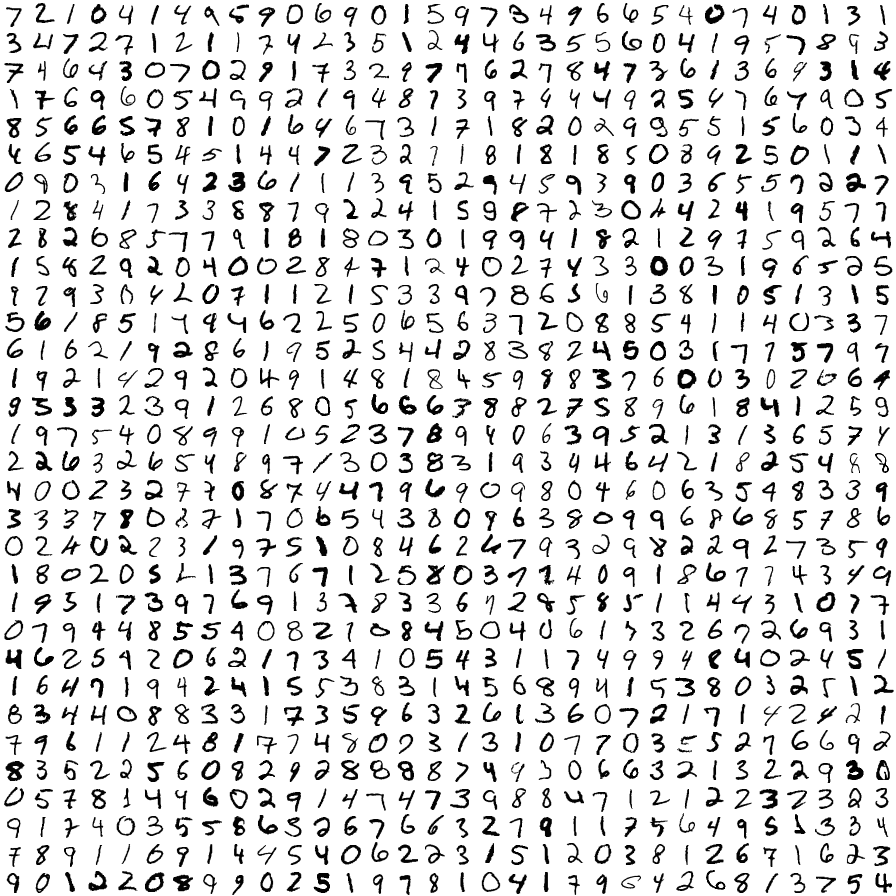

In [ ]:

from IPython.display import Image,display
img = display(Image('sprite_1024.png',height=500,width=500))